In [30]:
import torch
from torch import optim, nn
import torchvision
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from Preprocess import Anime
from net import ResNet18
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
from tqdm import trange
from sklearn.model_selection import KFold

In [31]:
batchze = 32
lr = 1e-3
epochs = 10
device = torch.device('cuda')
torch.manual_seed(1234)
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [32]:
# load data 
all_db = Anime('..\\Images', 224, 'all')
# train_db = Anime('..\\Images', 224, 'train')
# val_db = Anime('..\\Images', 224, 'val')
# test_db = Anime('..\\Images', 224, 'test')

In [33]:
# train_loader = DataLoader(train_db,batch_size= batchze, shuffle= True, num_workers=4)
# val_loader = DataLoader(val_db,batch_size= batchze, num_workers=2)
# test_loader = DataLoader(test_db,batch_size= batchze, num_workers=2)



In [34]:
# helper function
def evaluate(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x , y in loader:
        x, y  = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim = 1)
        correct += torch.eq(pred, y).sum().float().item()
    return correct / total

def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct
    

In [36]:

model = ResNet18(50).to(device)
optimizer = optim.Adam(model.parameters(),lr = lr)
criteon = nn.CrossEntropyLoss()
loss_data = []
val_acc_data = []
best_acc, best_epoch = 0, 0
global_step = 0
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(all_db)))):
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(all_db, batch_size=batchze, sampler=train_sampler)
    test_loader = DataLoader(all_db, batch_size=batchze, sampler=test_sampler)

    for epoch in range(epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criteon,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criteon)
        # calculate data
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                            epochs,
                                                                                                            train_loss,
                                                                                                            test_loss,
                                                                                                            train_acc,
                                                                                                            test_acc))
        # keep data
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc) 



# print("loaded from checkpoint! ")

# test_acc = evaluate(model, test_loader)
# print("test acc:", test_acc)


Epoch:1/50 AVG Training Loss:3.813 AVG Test Loss:3.880 AVG Training Acc 8.96 % AVG Test Acc 2.22 %
Epoch:2/50 AVG Training Loss:2.283 AVG Test Loss:3.347 AVG Training Acc 39.05 % AVG Test Acc 17.78 %
Epoch:3/50 AVG Training Loss:1.329 AVG Test Loss:2.915 AVG Training Acc 64.68 % AVG Test Acc 15.56 %
Epoch:4/50 AVG Training Loss:0.800 AVG Test Loss:2.667 AVG Training Acc 77.86 % AVG Test Acc 33.33 %
Epoch:5/50 AVG Training Loss:0.450 AVG Test Loss:2.573 AVG Training Acc 90.30 % AVG Test Acc 33.33 %
Epoch:6/50 AVG Training Loss:0.241 AVG Test Loss:2.334 AVG Training Acc 96.02 % AVG Test Acc 37.78 %
Epoch:7/50 AVG Training Loss:0.126 AVG Test Loss:2.374 AVG Training Acc 98.01 % AVG Test Acc 40.00 %
Epoch:8/50 AVG Training Loss:0.106 AVG Test Loss:2.624 AVG Training Acc 98.26 % AVG Test Acc 33.33 %
Epoch:9/50 AVG Training Loss:0.073 AVG Test Loss:2.459 AVG Training Acc 98.76 % AVG Test Acc 40.00 %
Epoch:10/50 AVG Training Loss:0.089 AVG Test Loss:2.601 AVG Training Acc 98.26 % AVG Test Acc

In [37]:

avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc)) 

Performance of 10 fold cross validation
Average Training Loss: 0.0413 	 Average Test Loss: 0.3692 	 Average Training Acc: 98.969 	 Average Test Acc: 90.849


Text(0.5, 1.0, 'val_acc')

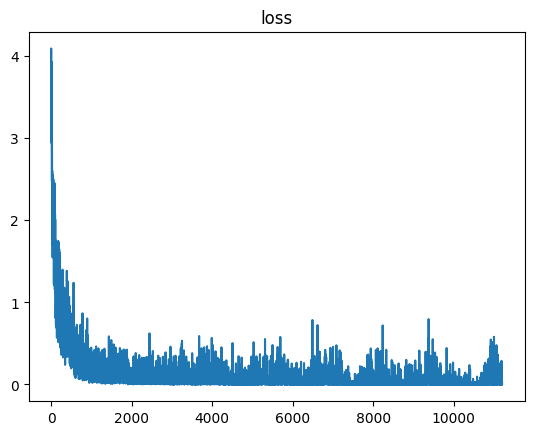

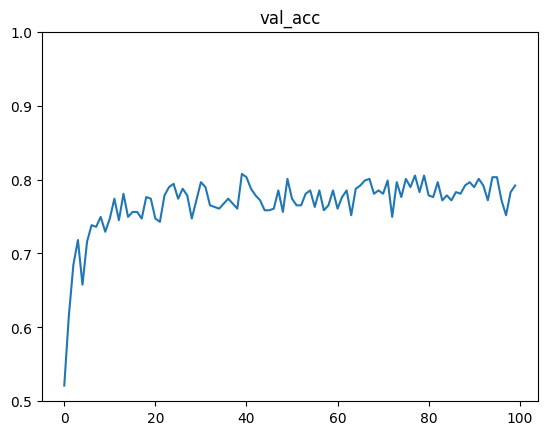

In [ ]:
# display the picture of loss and val_acc
x = np.arange(0, global_step)
x_2 = np.arange(0,epoch + 1)
fig, ax = plt.subplots()
ax.plot(x, loss_data)
ax.set_title('loss')
fig2, ax2 = plt.subplots()
ax2.plot(x_2,val_acc_data)
plt.ylim([0.5, 1])
ax2.set_title('val_acc')

In [ ]:
p = sum(map(lambda p:p.numel(), model.parameters()))
print('parameters size:', p)

parameters size: 1274610
